In [75]:
import rdkit.Chem
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Descriptors import ExactMolWt
from mordred import Calculator, descriptors
import matplotlib.pyplot as plt

I wanted to have to calculate only descriptors of my choice to avoid any unnessary computational overload. The way it can be done is [explained in this GitHub issue](https://github.com/mordred-descriptor/mordred/issues/73)
## Note:
This script currently calculates only 2D descriptors. Note that 3D descriptors (commented out in the cell below) can be easily calculated using Mordred too, it just required 3D structures (which can be generated either using DataWarrior or RDKit itself). Please see [this thread](https://github.com/mordred-descriptor/mordred/issues/93) for a detailed discussion (the last few comments explain how to do it step-by-step).

In [76]:
desc_needed = {'SIC0': 'Basak SIC0',
               'IC0': 'Basak IC0',
               'CIC0': 'Basak CIC0',
               #'nRot': 'Number of rotatable bonds',
               #'nN': 'Number of Nitrogen atoms',
               'nH': 'Number of Hydrogen atoms',
               'nC': 'Number of Carbon atoms',
               #'nS': 'Number of Sulphur atoms',
               'nO': 'Number of Oxygen atoms',
               #'nHBDon': 'Number of H-Bond donors',
               #'nHBAcc': 'Number of H-Bond acceptors',
               #'GeomDiameter': 'Geometrical Diameter',
               #'GeomRadius': 'Geometrical Radius',
               'TopoPSA': 'Topological PSA',
               #'SLogP': 'SLogP',
               #'RASA': 'RASA',
               #'TASA': 'TASA',
               #'TPSA': 'TPSA',
               #'RNCS': 'RNCS',
               #'RPCS': 'RPCS',
               #'RPSA': 'RPSA'
              }

calc = Calculator(descriptors, ignore_3D=False)
calc.descriptors = [d for d in calc.descriptors if str(d) in desc_needed.keys()]

In [77]:
# I thought of creating a "MoleculeInfo" object which would store info about all descriptors
# this wasn't needed, just one way I thought I could make the code more readable
class MoleculeInfo:
    def __init__(self, smiles, gen, mol):
        self.smiles = smiles
        self.gen = gen
        self.mol = mol
        # initialize the rest as -1 by default. Can assign them values later on.
        self.numC = -1
        self.numH = -1
        self.numO = -1
        self.IC0 = -1
        self.SIC0 = -1
        self.CIC0 = -1
        self.TopoPSA = -1
        
    def __repr__(self):
        # separate everything by a comma
        return(','.join([('G' + str(self.gen)), self.smiles, str(self.numC), str(self.numH), str(self.numO),
                         str(self.IC0), str(self.SIC0), str(self.CIC0), str(self.TopoPSA)]))

Note: this part of the code was for some specialized purpose.
Load the contents in the SDF and store them in a list.

In [78]:
'''sdf_data = rdkit.Chem.SDMolSupplier('smi_siddhant.sdf')
# so sdf_data is apparently a list of RDKit Mol objects
for item in sdf_data:
    smi = rdkit.Chem.MolToSmiles(item)
    print(smi)'''

"sdf_data = rdkit.Chem.SDMolSupplier('smi_siddhant.sdf')\n# so sdf_data is apparently a list of RDKit Mol objects\nfor item in sdf_data:\n    smi = rdkit.Chem.MolToSmiles(item)\n    print(smi)"

In [79]:
all_molecules_info = []
# open the output .txt
count = 0
with open('../main/glucose/glucose_degradation_output.txt') as glu_out:
    contents = glu_out.readlines()
    for line in contents:
        # get rid of \n at the end of the line
        line = line.rstrip('\n')
        # break line into components separated by a tabspace
        comps = line.split("\t")
        gen_num = int(comps[0][1])
        smiles = comps[1]
        mol = MolFromSmiles(smiles)
        mol_info = MoleculeInfo(smiles, gen_num, mol)
        all_molecules_info.append(mol_info)
        # testing with the first 100 molecules
        '''if count > 100:
            break'''
        count += 1

In [80]:
result = calc.pandas([mol_info.mol for mol_info in all_molecules_info])

100%|██████████| 48401/48401 [00:39<00:00, 1231.74it/s]


In [81]:
result.head()

,nH,nC,nO,IC0,SIC0,CIC0,TopoPSA
0,4,2,2,1.500000,0.500000,1.500000,37.30
1,8,4,4,1.500000,0.375000,2.500000,77.76
2,12,6,6,1.500000,0.327156,3.084963,118.22
3,12,6,7,1.516624,0.326587,3.127232,138.45
4,14,6,6,1.457266,0.310028,3.243174,121.38


In [82]:
# was testing something
to_find = 'C(C(C=O)(C(C(O)=O)=CCO)O)=O'
for i in range(len(all_molecules_info)):
    if all_molecules_info[i].smiles == to_find:
        print('index i=', i)

index i= 25988


In [83]:
start = 0 #23878
#print(all_molecules_info[start])
for i in range(start, len(result)):
    all_molecules_info[i].numC = result['nC'].iloc[i]
    all_molecules_info[i].numH = result['nH'].iloc[i]
    all_molecules_info[i].numO = result['nO'].iloc[i]
    all_molecules_info[i].IC0 = result['IC0'].iloc[i]
    all_molecules_info[i].SIC0 = result['SIC0'].iloc[i]
    all_molecules_info[i].CIC0 = result['CIC0'].iloc[i]
    all_molecules_info[i].TopoPSA = result['TopoPSA'].iloc[i]

# see the top item in the list
print(all_molecules_info[0])


G1,C(CO)=O,2,4,2,1.5,0.5,1.5,37.3


In [74]:
with open('descriptors_2d.csv', 'w') as desc_csv:
    desc_csv.write(','.join(['Generation', 'SMILES', 'numC', 'numH', 'numO', 'IC0', 'SIC0', 'CIC0', 'TopoPSA']))
    desc_csv.write('\n')
    for info in all_molecules_info:
        desc_csv.write(str(info))
        desc_csv.write('\n')
print("Finished writing", desc_csv)

Finished writing <_io.TextIOWrapper name='descriptors_2d.csv' mode='w' encoding='UTF-8'>


In [34]:
print(len(result))

48401


The Dataframe can be easily exported into a CSV as well

In [33]:
print(type(result['nH'].iloc[1]))

<class 'numpy.int64'>


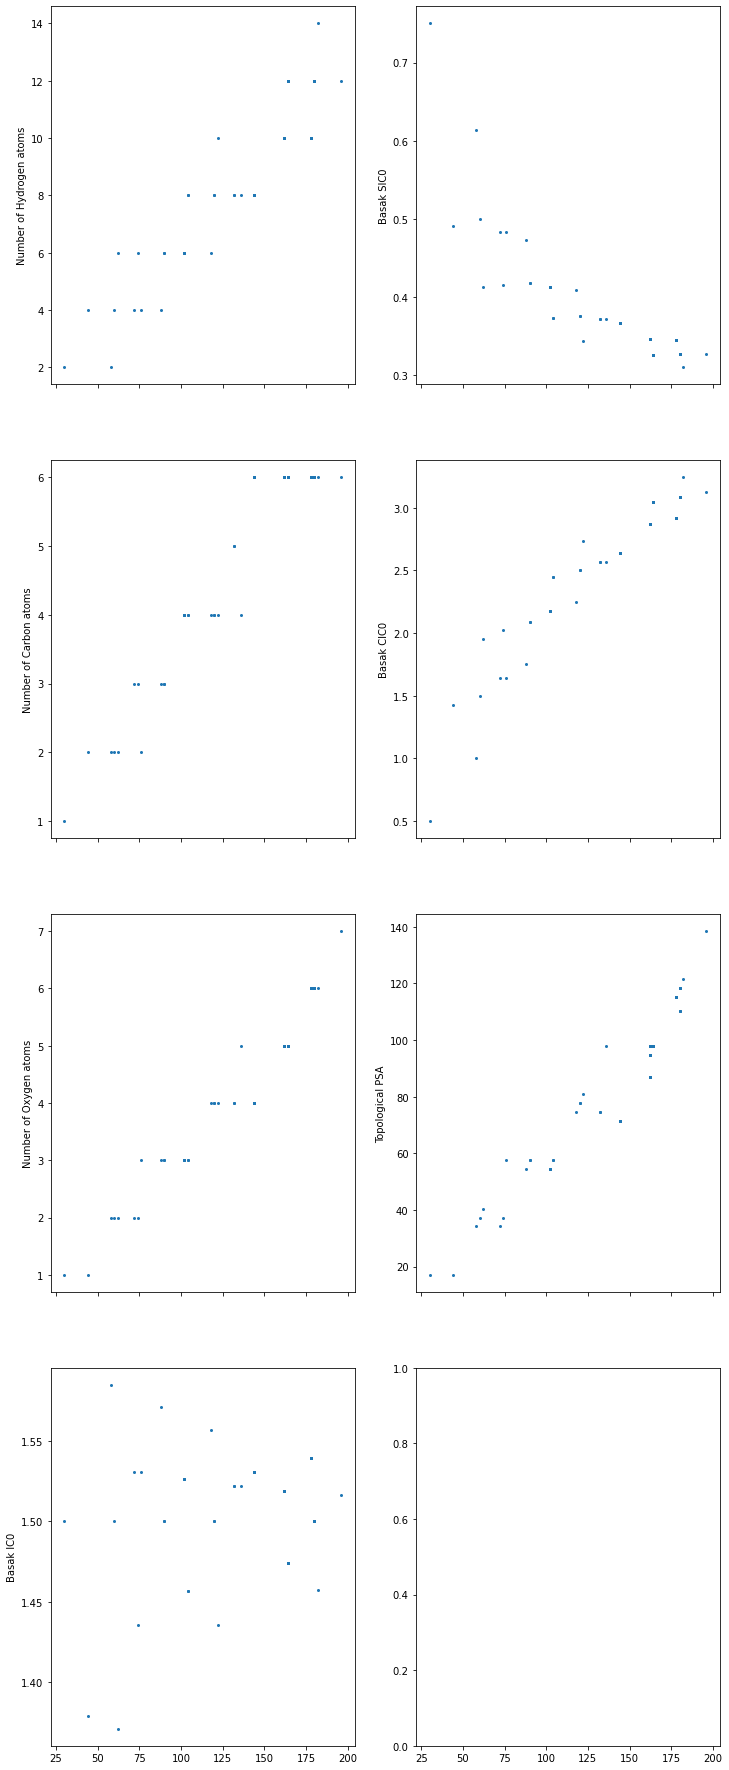

In [8]:
fig = plt.figure(figsize=(12,32))
axes = fig.subplots(nrows=4, ncols=2, sharex=True)
for col_id, col in enumerate(result.columns):
    axes[col_id%4, col_id//4].plot(weights_list, result[col], linestyle='', marker='o', markersize=2)
    axes[col_id%4, col_id//4].set_ylabel(desc_needed[col])